In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost.sklearn import XGBClassifier
from sklearn import metrics

## xgboost

In [82]:
PARAMS = {'learning_rate': 0.06,
          'n_estimators': 300,
          'max_depth': 5,
          'min_child_weight': 1,
          'gamma': 0.3,
          'reg_alpha': 0.005,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'objective': 'binary:logistic',
          'nthread': 4,
          'seed': 27,
          'scale_pos_weight': 1}

In [83]:
from lxml import etree
parser=etree.XMLParser(load_dtd= True)
tree = etree.parse("/Users/huzuoliang/Desktop/features.xml",parser)
root = tree.getroot()
names=[]
target_names=''
featrue_names=[]
oh={}
for f in root:
    f_type = f.tag
    f_name = f.get('name')
    names.append(f_name)
    ohrange = f.getchildren()[0]
    targetFlag = f.getchildren()[2]
    trainFlag = f.getchildren()[3]
    onFlag = f.getchildren()[4]
    
    if targetFlag.text == 'true':
        target_names = f_name
    if trainFlag.text == 'true':
        featrue_names.append(f_name)
        oh[f_name] = list(range(-1,int(ohrange.text)))

In [95]:
data1 = pd.read_csv('/Users/huzuoliang/Desktop/train_set/ajk/ec',sep='\t',names=names)
data2 = pd.read_csv('/Users/huzuoliang/Desktop/train_set/ajk/ec2',sep='\t',names=names)
data = pd.concat([data1,data2],axis=0,ignore_index=True)

In [96]:
data1.shape,data2.shape

((77392, 107), (68639, 107))

In [97]:
data.max(axis=0).map(lambda x:int(x))

label                                          1
hour_expo_oh                                   5
minute_expo_oh                                 1
model_oh                                       3
city_id                                       59
pro_id                                1115797643
broker_id                                5076559
region_id                                   5406
subregion_id                               22573
comm_id                                  1006035
rent_type_oh                                   1
room_num_oh                                    4
hall_num_oh                                    4
toilet_num_oh                                  4
pro_area_id_oh                                 7
paymoney_num_oh                               12
pro_floor_oh                                   3
pro_floor_num_oh                               3
decorate_oh                                    6
price_desc_oh                                 10
toward_oh           

In [98]:
train = data[featrue_names]
label = data[target_names]

In [99]:
label

0         0
1         0
2         1
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        1
11        0
12        0
13        1
14        0
15        0
16        0
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26        1
27        0
28        0
29        1
         ..
146001    0
146002    0
146003    0
146004    1
146005    1
146006    0
146007    0
146008    0
146009    0
146010    0
146011    0
146012    0
146013    0
146014    0
146015    0
146016    0
146017    0
146018    1
146019    0
146020    1
146021    1
146022    0
146023    0
146024    0
146025    0
146026    0
146027    0
146028    0
146029    0
146030    0
Name: label, Length: 146031, dtype: int64

In [100]:
oh_cols = pd.DataFrame()
for k,v in oh.items():
    cols_name_oh = pd.get_dummies(v).rename(lambda x: k +'_'+ str(v[x])).T
    k_oh = cols_name_oh.loc[train[k]]
    k_oh.reset_index(inplace=True)
    # reset_index后会自动加一个index,以保存原始的列index
    # 避免settingwithcopyWarning
    k_oh = k_oh.drop('index', axis=1)
    oh_cols = pd.concat([oh_cols,k_oh], axis=1)

In [101]:
oh_cols.shape,label.shape

((146031, 398), (146031,))

In [102]:
len(label)

146031

In [103]:
all_data = pd.concat([oh_cols,label],axis=1)

In [104]:
from sklearn.utils import shuffle  
all_data = shuffle(all_data) 
train = all_data.head(int(sz[0] * 0.8)) 
test = all_data.tail(int(sz[0] * 0.2))

In [105]:
predictors = [x for x in train.columns if x not in [target_names]]

In [106]:
xgb = XGBClassifier(**PARAMS)
xgb.fit(train[predictors], train[target_names], eval_metric='auc')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.3, learning_rate=0.06,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=300, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0.005, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=True, subsample=0.8)

AUC Score (Train): 0.750108
Logloss Score (Train): 0.408236


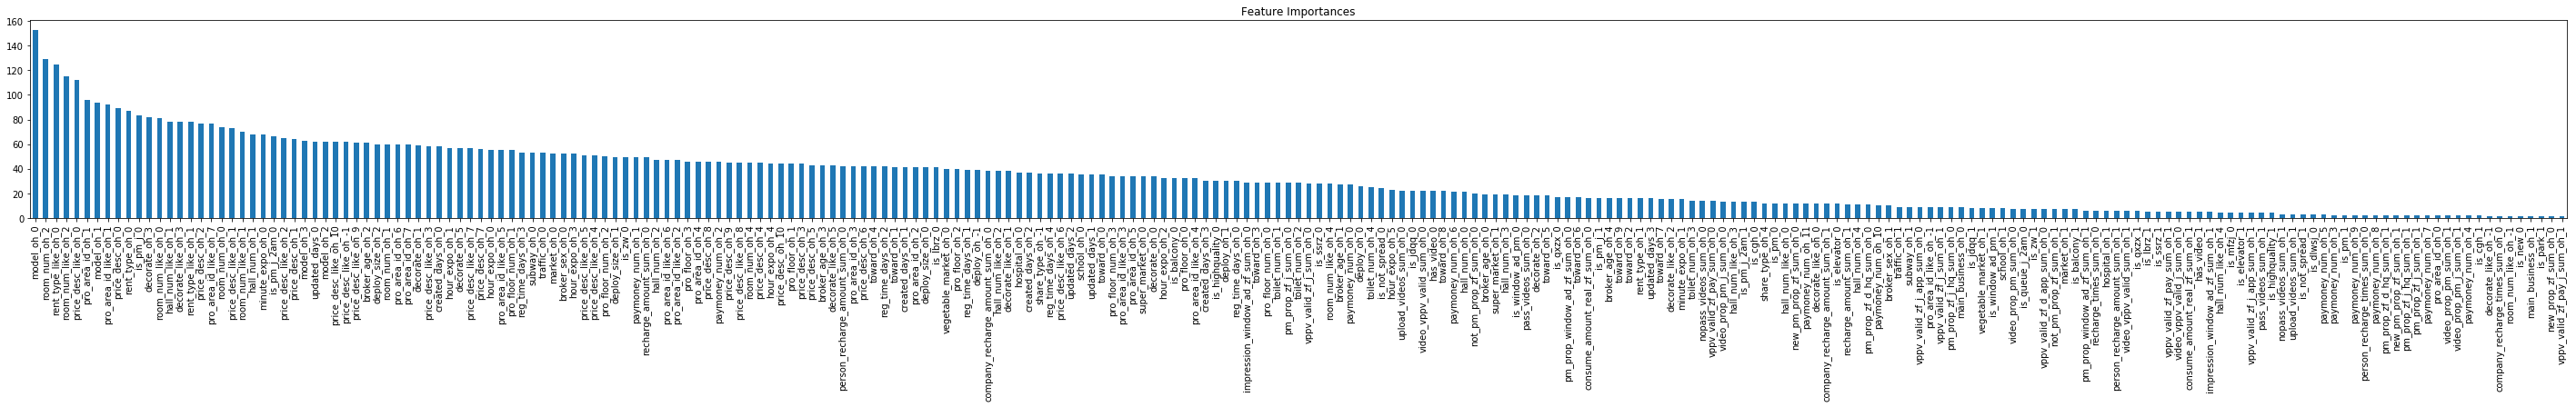

In [107]:
pre_labels = xgb.predict_proba(test[predictors])[:, 1]

print('AUC Score (Train): %f' % metrics.roc_auc_score(test[target_names], pre_labels))
print('Logloss Score (Train): %f' % metrics.log_loss(test[target_names], pre_labels))

plt.figure(figsize=(50,4))
feat_imp = pd.Series(xgb.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.show()

In [108]:
pre_labels

array([ 0.05548057,  0.46205914,  0.12135143, ...,  0.16841671,
        0.2297314 ,  0.22865671], dtype=float32)

## LR

In [109]:
from sklearn.linear_model import LogisticRegression

In [146]:
lr = LogisticRegression(C=0.25,max_iter=1000)

In [147]:
lr.fit(train[predictors], train[target_names])

LogisticRegression(C=0.25, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [148]:
predprob = lr.predict_proba(test[predictors])[:, 1]
print('AUC Score (Train): %f' % metrics.roc_auc_score(test[target_names], predprob))
print('Logloss Score (Train): %f' % metrics.log_loss(test[target_names], predprob))

AUC Score (Train): 0.630444
Logloss Score (Train): 0.455529


## xgboost+LR1

In [149]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
enc = OneHotEncoder()

In [150]:
leaves = xgb.apply(all_data[predictors])

In [151]:
enc.fit(leaves)
leaves = enc.transform(leaves).toarray()

In [152]:
train_num = int(leaves.shape[0] * 0.8)

In [157]:
# LR
lr = LogisticRegression(C=0.0025,max_iter=2500)
lr.fit(leaves[:train_num], all_data[target_names][:train_num])

LogisticRegression(C=0.0025, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=2500,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [158]:
predprob = lr.predict_proba(leaves[train_num:])[:, 1]
print ("GBDT+LR Accuracy (Train): %.4g" % metrics.roc_auc_score(all_data['label'][train_num:], predprob))
print('Logloss Score (Train): %f' % metrics.log_loss(all_data['label'][train_num:], predprob))

GBDT+LR Accuracy (Train): 0.7611
Logloss Score (Train): 0.402742


## xgboost+LR2

In [159]:
all_oh = np.concatenate((leaves, all_data[predictors].values), axis=1)

In [160]:
train_num = int(all_oh.shape[0] * 0.8)

In [163]:
lr = LogisticRegression(C=0.0025,max_iter=2500)
lr.fit(all_oh[:train_num], all_data[target_names][:train_num])

LogisticRegression(C=0.002, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=2500, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [164]:
predprob = lr.predict_proba(all_oh[train_num:])[:, 1]
print ("GBDT+LR AUC (Train): %.4g" % metrics.roc_auc_score(all_data['label'][train_num:], predprob))
print('Logloss Score (Train): %f' % metrics.log_loss(all_data['label'][train_num:], predprob))

GBDT+LR AUC (Train): 0.7611
Logloss Score (Train): 0.402931
